# Processed Data Visualization Notebook

In [21]:
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path
import re

## Open Processed Simulation Output

In [22]:
h5f = h5py.File("../data/processed/proc_sims_v5.h5", "r")

## Data Structure

In [23]:
print("Top-Level:\n", list(h5f.keys()))
print("Header:\n", list(h5f["sims"]))
print("sim<n>:\n", list(h5f["sims"]["sim1"]))
print("params:\n", list(h5f["sims"]["sim1"]["params"]))
print("output:\n", list(h5f["sims"]["sim1"]["output"]))
print("cl:\n", list(h5f["sims"]["sim1"]["cl"]))

Top-Level:
 ['sims']
Header:
 ['sim0', 'sim1', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim19', 'sim2', 'sim20', 'sim21', 'sim22', 'sim23', 'sim24', 'sim25', 'sim26', 'sim27', 'sim28', 'sim29', 'sim3', 'sim30', 'sim31', 'sim32', 'sim33', 'sim34', 'sim35', 'sim36', 'sim37', 'sim38', 'sim39', 'sim4', 'sim40', 'sim41', 'sim42', 'sim43', 'sim44', 'sim45', 'sim46', 'sim47', 'sim48', 'sim49', 'sim5', 'sim50', 'sim51', 'sim52', 'sim53', 'sim54', 'sim55', 'sim56', 'sim57', 'sim58', 'sim59', 'sim6', 'sim60', 'sim61', 'sim62', 'sim63', 'sim64', 'sim65', 'sim66', 'sim67', 'sim68', 'sim69', 'sim7', 'sim70', 'sim71', 'sim72', 'sim73', 'sim74', 'sim75', 'sim76', 'sim77', 'sim78', 'sim79', 'sim8', 'sim80', 'sim81', 'sim82', 'sim83', 'sim84', 'sim85', 'sim86', 'sim87', 'sim88', 'sim89', 'sim9', 'sim90', 'sim91', 'sim92', 'sim93', 'sim94', 'sim95', 'sim96', 'sim97', 'sim98', 'sim99']
sim<n>:
 ['cl', 'output', 'params']
params:
 ['alpha_zre', 'b0_zre', 'kb_zre', 

## Build DataFrame

In [24]:
rows = []
sims = h5f["sims"]

# Iterate through all sims in sims/
for name in sorted(sims.keys(), key=lambda s: int(s[3:]) if s.startswith("sim") and s[3:].isdigit() else s):
    g = sims[name]
    rows.append({
        "sim": name,
        # Parameters
        "alpha_zre": float(g["params/alpha_zre"][()]),
        "kb_zre": float(g["params/kb_zre"][()]),
        "zmean_zre": float(g["params/zmean_zre"][()]),
        "b0_zre": float(g["params/b0_zre"][()]),
        "tau": float(g["output/tau"][()]),
        # Info about per-sim grids
        "n_z": int(g["output/zval_list"].shape[0]),
        "n_xm": int(g["output/xmval_list"].shape[0]),
    })

df = pd.DataFrame(rows)
df.head()

,sim,alpha_zre,kb_zre,zmean_zre,b0_zre,tau,n_z,n_xm
0,sim0,0.123569,0.361813,8.026353,0.59312,0.061644,26,26
1,sim1,0.658593,1.319570,8.276313,0.59312,0.063535,26,26
2,sim2,0.569787,0.369425,8.481533,0.59312,0.064694,26,26
3,sim3,0.151896,1.349346,8.802202,0.59312,0.069647,26,26
4,sim4,0.194290,1.111912,7.723515,0.59312,0.058893,26,26


## Simulation Parameters
- **`alpha`** (0.10 - 0.90) : Controls how long reionization lasts.
- **`kb`** (0.10 - 2.0) : Determines how uneven the ionized regions are (higher values more clustered).
- **`zmean`** (7.0 - 9.0) : Sets the midpoint of reionization.
- **`b0`** (0.40 - 2.0) : Adjusts the overall strength or amplitude of the ionization field.

### Summary

In [25]:
def summarize(col):
    s = df[col]
    return {"min": s.min(), "max": s.max(), "mean": s.mean(), "std": s.std(ddof=1), "n_unique": s.nunique()}

summary = pd.DataFrame({c: summarize(c) for c in ["alpha_zre","kb_zre","zmean_zre", "b0_zre"]}).T
summary

,min,max,mean,std,n_unique
alpha_zre,0.106138,0.892581,0.500387,2.320735e-01,100.0
kb_zre,0.104399,1.987047,1.050257,5.515132e-01,100.0
zmean_zre,7.013623,8.984811,7.999837,5.803226e-01,100.0
b0_zre,0.593120,0.593120,0.593120,2.231632e-16,1.0


### Histogram of Parameter Space
- Histograms should be flat for uniform coverage.

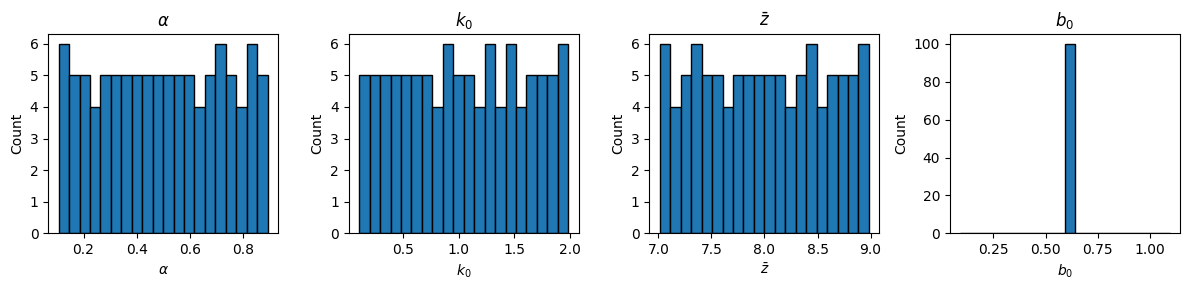

In [26]:
plt.figure(figsize=(12,3))

columns = ["alpha_zre", "kb_zre", "zmean_zre", "b0_zre"]
labels = [r"$\alpha$", r"$k_0$", r"$\bar{z}$", r"$b_0$"]

for i, (col, label) in enumerate(zip(columns, labels), 1):
    plt.subplot(1,4,i)
    plt.hist(df[col], bins=20, edgecolor="black")
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.show()

### Spearman Correlation (Independence)
- Measure how monotonic the relationship is between pairs or parameters.
- +1.0 : Perfect increasing monotonic relation
- -1.0 : Perfect decreasing relation
-  0.0 : No Monotonic relation

In [27]:
df[["alpha_zre","kb_zre","zmean_zre"]].corr(method="spearman")

,alpha_zre,kb_zre,zmean_zre
alpha_zre,1.000000,-0.14345,0.054917
kb_zre,-0.143450,1.00000,-0.138830
zmean_zre,0.054917,-0.13883,1.000000


### Coverage of Parameter Space
- `Min Pairwise Distance`: The smallest distance between any two parameters.
- `Median Pairwise Distance`: The median distance among all pairs of parameters.
- `Distribution of Pairwise Distances`: Visualize the distribution of distances.

Min Pairwise Distance: 0.026
Median Pairwise Distance: 0.675


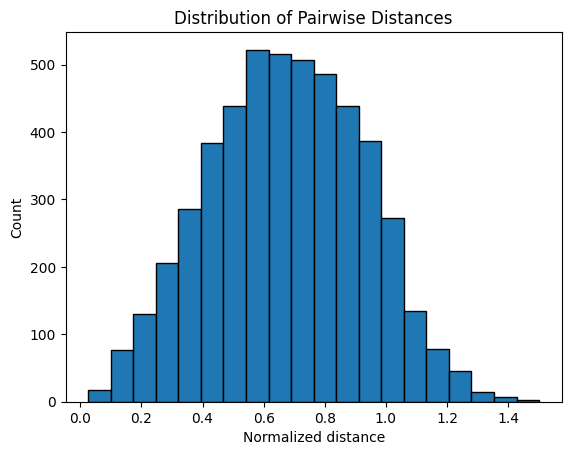

In [28]:
X = df[["alpha_zre","kb_zre","zmean_zre"]].to_numpy()
# Normalize to [0,1]
Xn = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
D = pdist(Xn)

print(f"Min Pairwise Distance: {np.min(D):.3f}")
print(f"Median Pairwise Distance: {np.median(D):.3f}")

plt.figure()
plt.hist(D, bins=20, edgecolor='black')
plt.title("Distribution of Pairwise Distances")
plt.xlabel("Normalized distance")
plt.ylabel("Count")
plt.show()

## Simulation Output
- **`tau`** - The optical depth to reionization; measures how many CMB photons were scattered by free electrons.
- **`xmval_list`** - The average ionized fraction of the universe at different times; shows how reionization progressed.
- **`zval_list`** - The redshift values that correspond to each point in the ionization history.
- **`pk_tt`** - The power spectrum computed from the simulation volume.
- **`ksz_map`** - A 2D map of temperature fluctuations caused by the kinematic Sunyaev–Zel’dovich effect.
- **`Tcmb0`** - The present-day mean CMB temperature used to convert maps into physical temperature units.
- **`theta_max_ksz`** - The angular size of the kSZ map, sets the total field of view and angular scale of the simulation patch.

### Check for Invalid or Empty Output

In [29]:
def sim_order(s):
    m = re.match(r"sim(\d+)$", s)
    return int(m.group(1)) if m else 10**9

bad = []
for s in sorted(h5f["sims"].keys(), key=sim_order):
    g = h5f["sims"][s]
    pk = g["output/pk_tt"][()]
    kz = g["output/ksz_map"][()]
    if pk.size == 0 or kz.size == 0 or np.any(~np.isfinite(pk)) or np.any(~np.isfinite(kz)):
        bad.append(s)
bad

[]

### kSZ Map Mean/STD Distribution

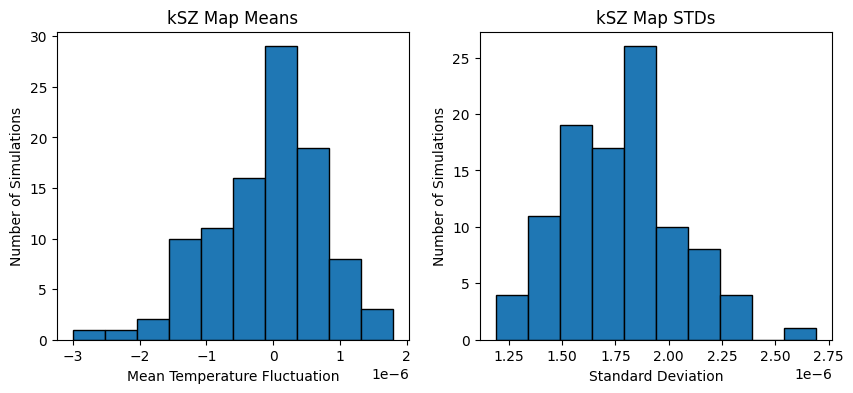

In [30]:
means, stds = [], []
for s in h5f["sims"].keys():
    m = h5f["sims"][s]["output/ksz_map"][()]
    means.append(float(np.mean(m)))
    stds.append(float(np.std(m)))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram for means
axes[0].hist(means, bins=10, edgecolor='black')
axes[0].set_title("kSZ Map Means")
axes[0].set_xlabel("Mean Temperature Fluctuation")
axes[0].set_ylabel("Number of Simulations")

# Plot histogram for stds
axes[1].hist(stds, bins=10, edgecolor='black')
axes[1].set_title("kSZ Map STDs")
axes[1].set_xlabel("Standard Deviation")
axes[1].set_ylabel("Number of Simulations")
plt.show()

### Tau Distribution Histogram

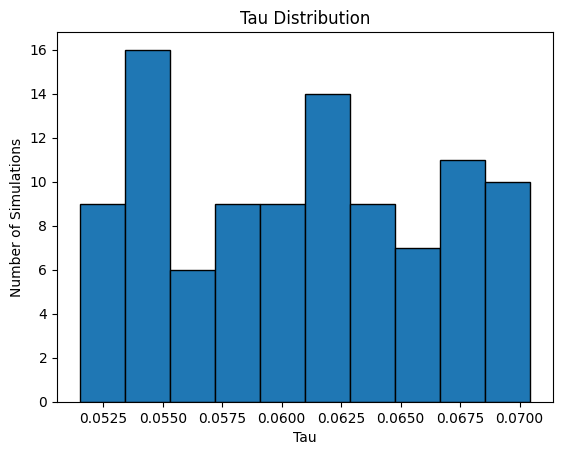

In [31]:
plt.figure()
df["tau"].hist(bins=10, edgecolor="black")
plt.grid(False)
plt.title("Tau Distribution")
plt.xlabel("Tau")
plt.ylabel("Number of Simulations")
plt.show()

### Tau vs Parameter Scatter Plots

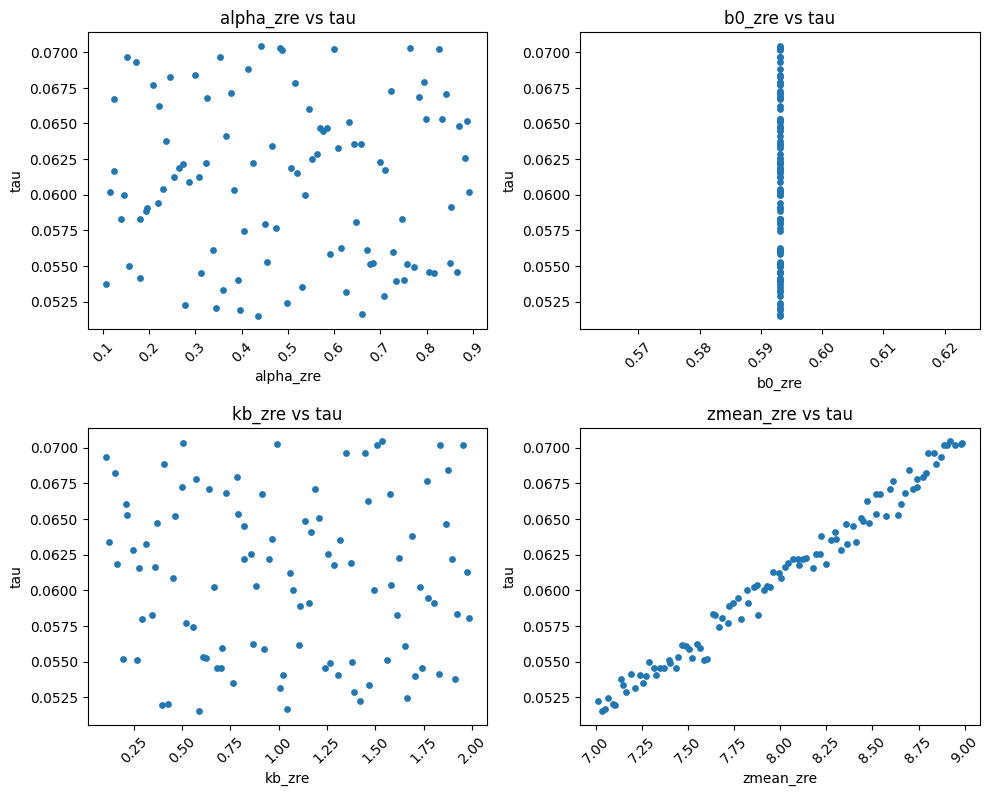

In [32]:
param_cols = ["alpha_zre", "b0_zre", "kb_zre", "zmean_zre"]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(param_cols):
    ax = axes[i]
    ax.scatter(df[p], df["tau"], s=15)
    ax.set_xlabel(p)
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylabel("tau")
    ax.set_title(f"{p} vs tau")

    ax.ticklabel_format(axis="x", style="plain", useOffset=False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Spearman Correlation with Tau
- +1.0 : Perfect increasing monotonic relation
- -1.0 : Perfect decreasing relation
-  0.0 : No Monotonic relation

In [33]:
df[param_cols + ["tau"]].corr(method="spearman")["tau"].sort_values(ascending=False)

tau          1.000000
zmean_zre    0.992895
alpha_zre   -0.010309
kb_zre      -0.056322
b0_zre            NaN
Name: tau, dtype: float64

### Ionization History as a Function of Redshift


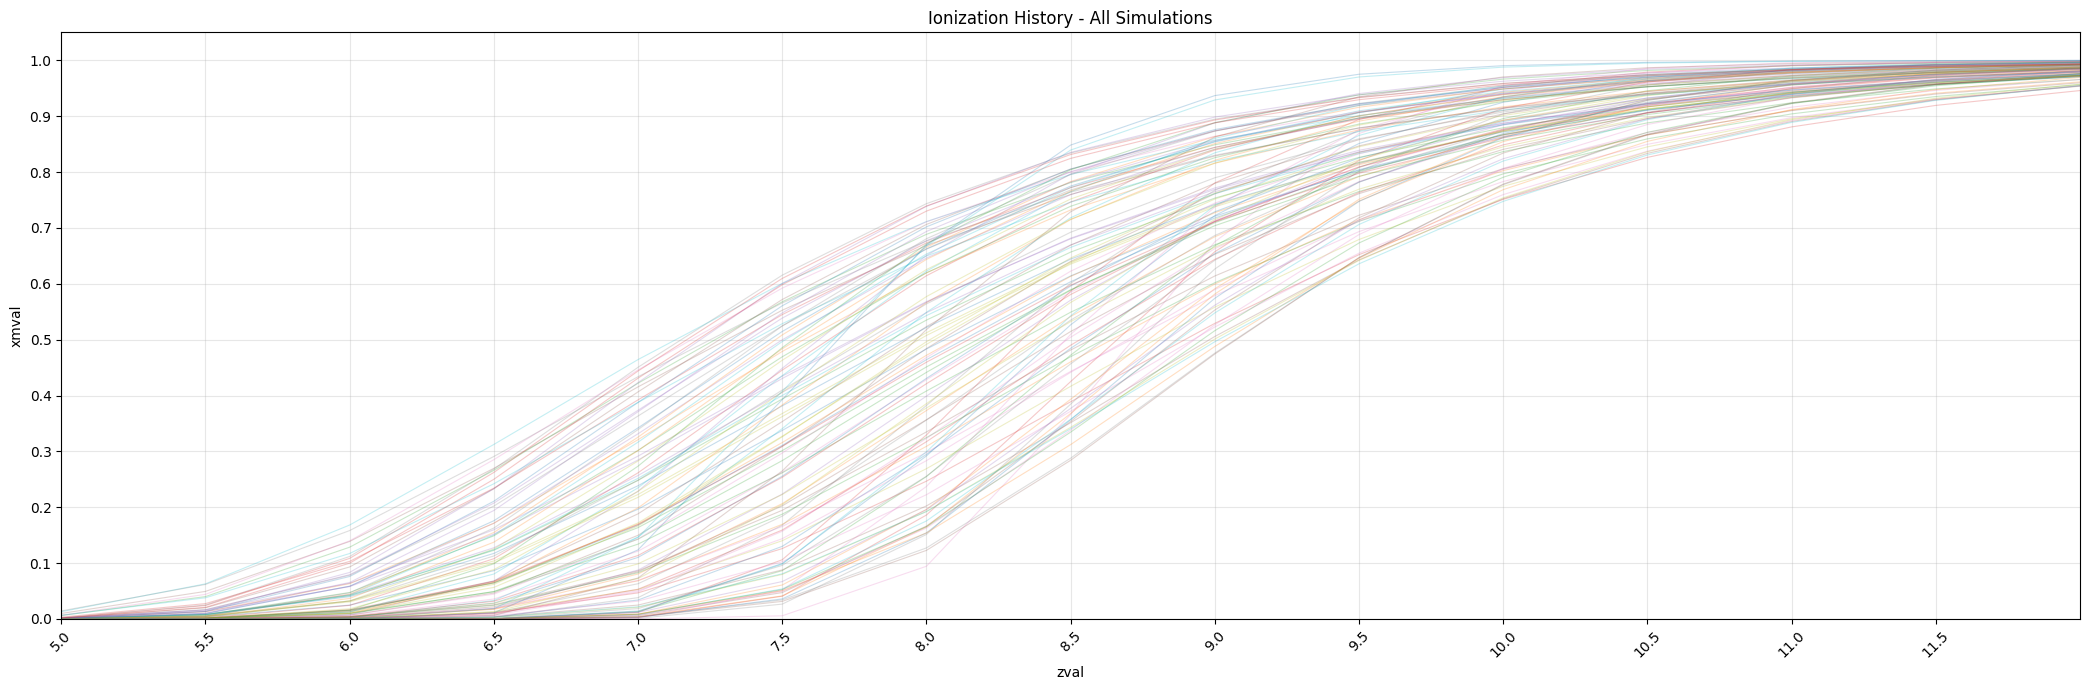

In [34]:
sims_grp = h5f["sims"]
sim_names = sorted(sims_grp.keys(), key=lambda s: (len(s), s))

plt.figure(figsize=(21, 7))
ax = plt.gca()

for sim in sim_names:
    z_path = f"sims/{sim}/output/zval_list"
    x_path = f"sims/{sim}/output/xmval_list"
    if z_path not in h5f or x_path not in h5f:
        continue

    z = np.array(h5f[z_path][()], dtype=float)
    x = np.array(h5f[x_path][()], dtype=float)

    order = np.argsort(z)
    z, x = z[order], x[order]

    ax.plot(z, x, lw=0.8, alpha=0.25)

ax.set_xlabel("zval")
ax.set_ylabel("xmval")
ax.set_title("Ionization History - All Simulations")
ax.grid(True, alpha=0.3)
ax.set_xticks(np.arange(5, 12, 0.5))
ax.tick_params(axis="x", rotation=45)
plt.xlim(5, 12)
ax.set_ylim(0, 1.05)
ax.yaxis.set_major_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.show()

### Ionization History with 50% ionization near z=8 and a duration of ~2 (in redshift)

/var/folders/x1/pcwgzc353ds7yw3lc318r_cc0000gn/T/ipykernel_4684/2204156264.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


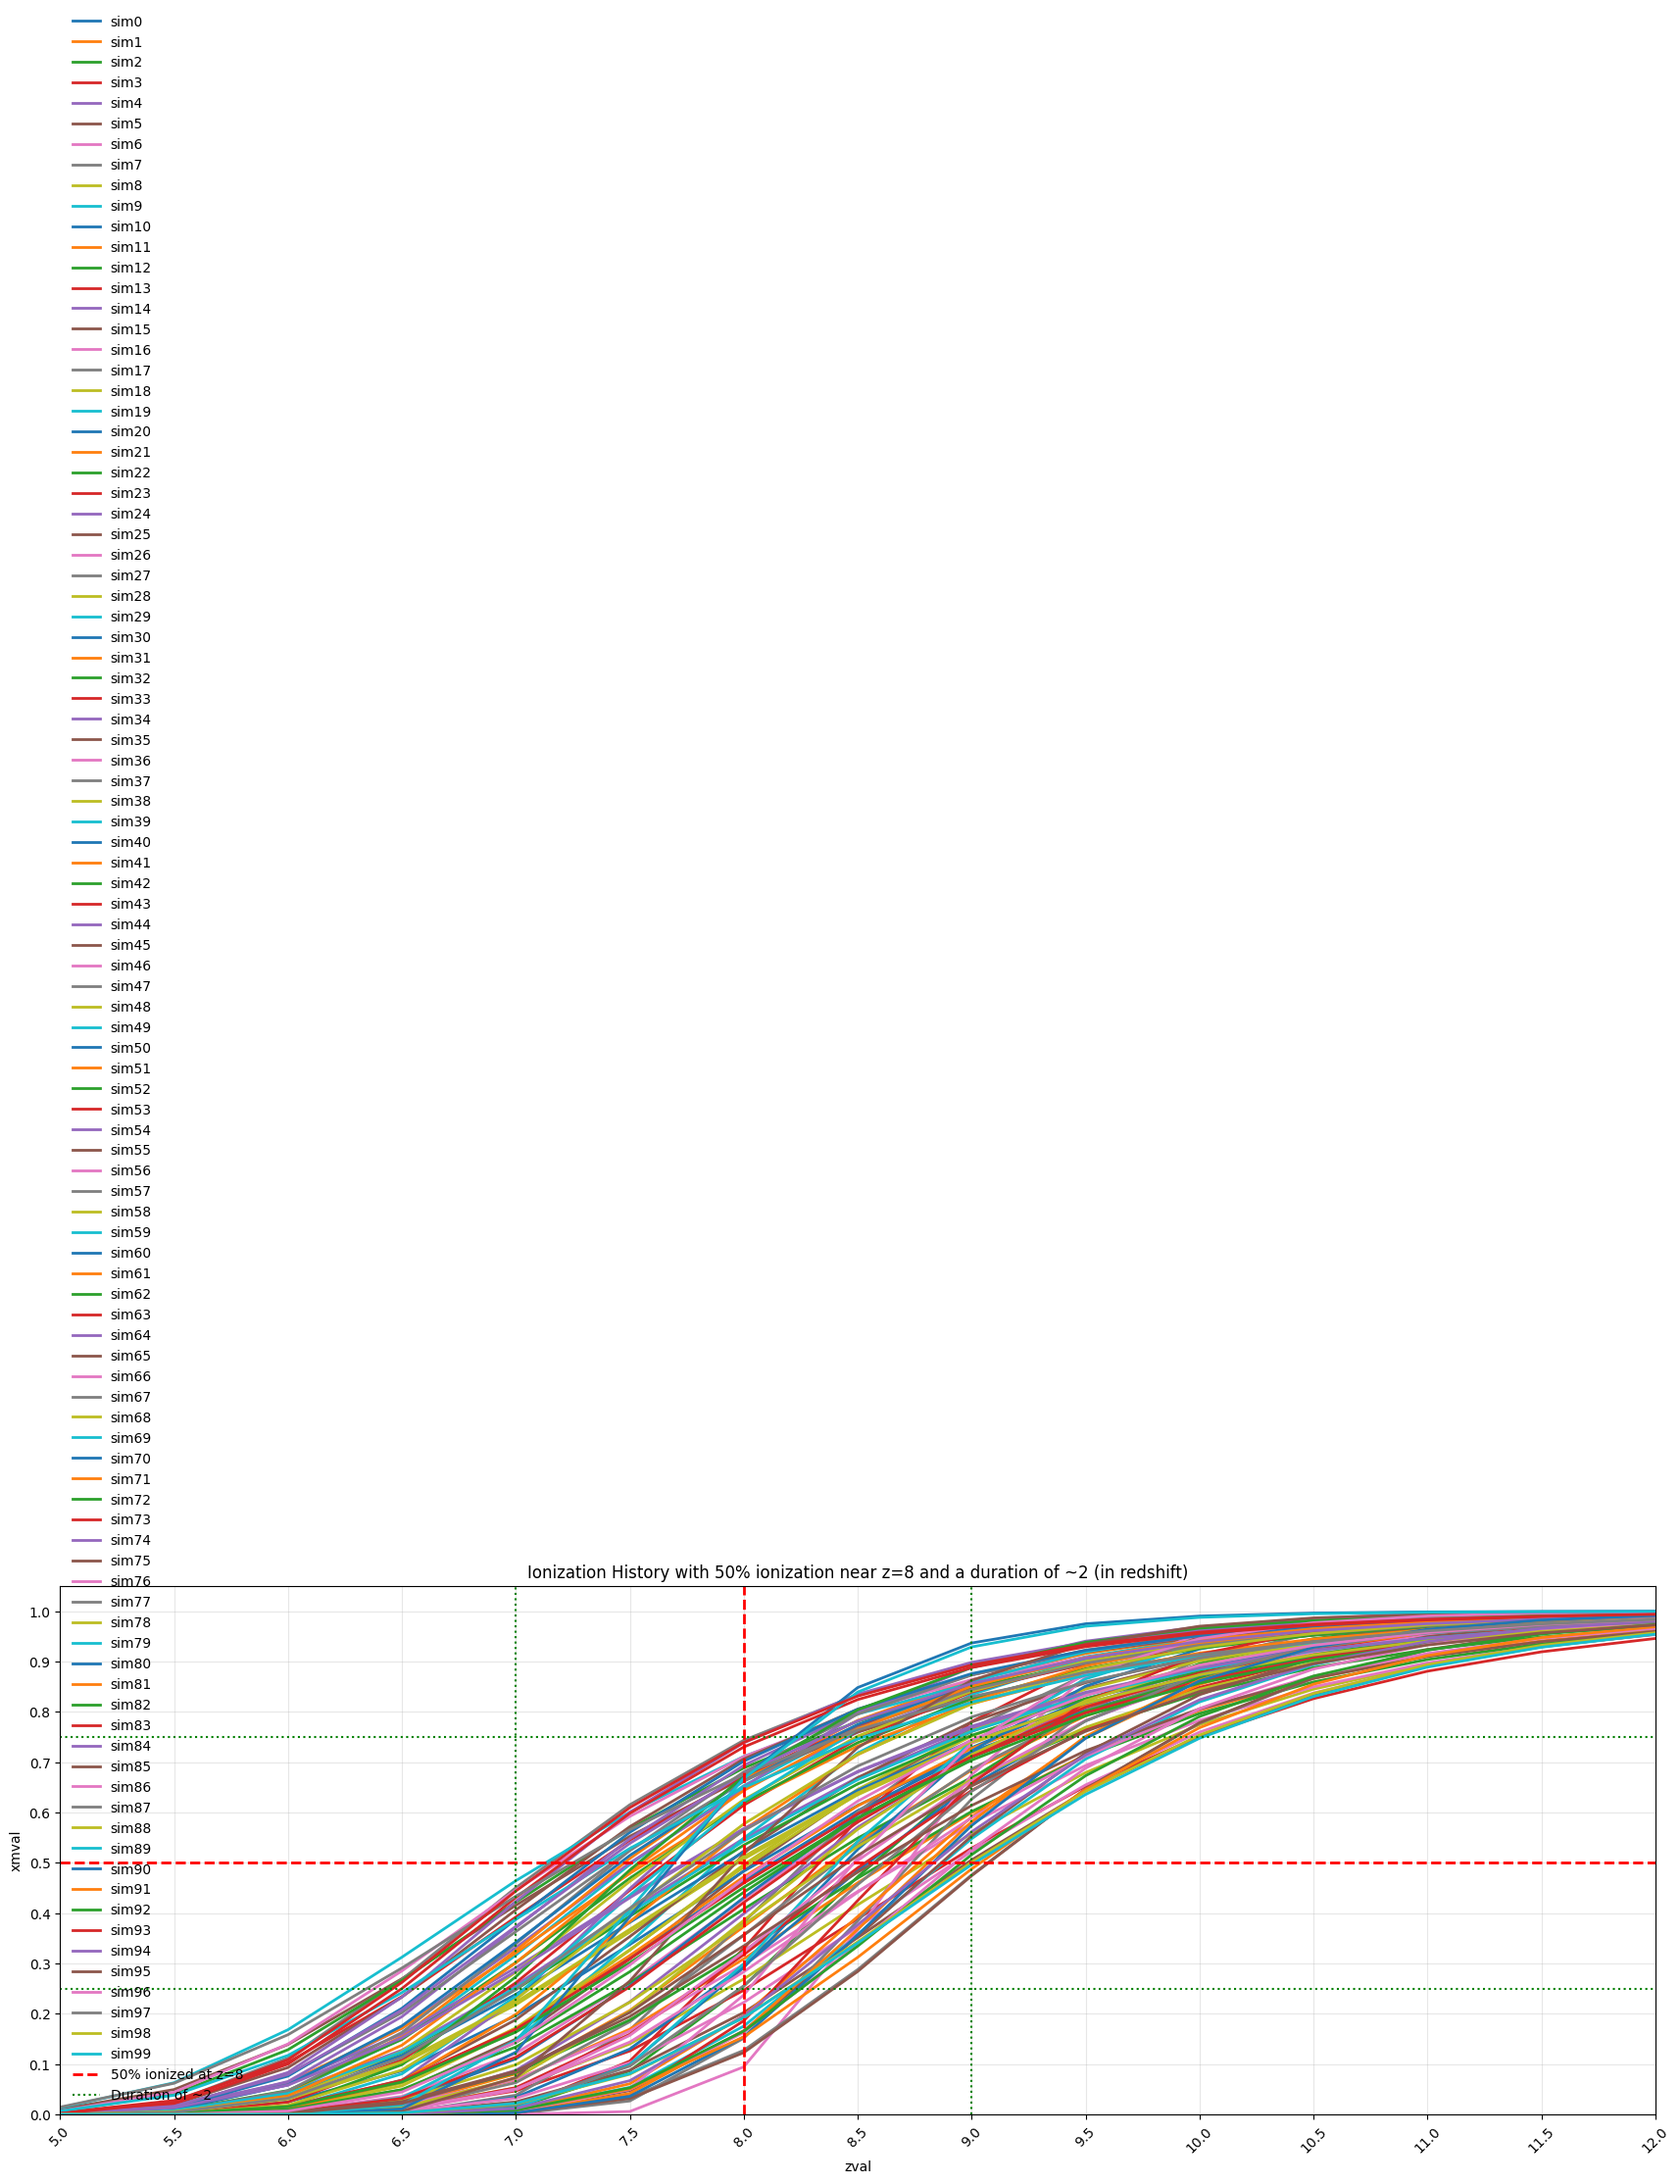

Simulation:	 sim99
alpha:		 0.441047309221394
k0:			 1.5357009099112104
zmean:		 8.922264828422325
b0:			 0.5931198102016607


In [35]:
sims_grp = h5f["sims"]
sim_names = sorted(sims_grp.keys(), key=lambda s: (len(s), s))

plt.figure(figsize=(21, 7))


# ---- Singular Sim ----
# sim = sim_names[1]

# z = np.array(h5f[f"sims/{sim}/output/zval_list"][()], dtype=float)
# x = np.array(h5f[f"sims/{sim}/output/xmval_list"][()], dtype=float)

# Sort by redshift
# order = np.argsort(z)
# z, x = z[order], x[order]


# plt.plot(z, x, lw=2, label=f"{sim}")

# ---- All Sims ----
for sim in sim_names:
    z = np.array(h5f[f"sims/{sim}/output/zval_list"][()], dtype=float)
    x = np.array(h5f[f"sims/{sim}/output/xmval_list"][()], dtype=float)

    # Sort by redshift
    order = np.argsort(z)
    z, x = z[order], x[order]

    plt.plot(z, x, lw=2, label=sim)

# 50% ionization near z=8
plt.axhline(0.50, color="red", ls="--", lw=2, label="50% ionized at z=8")
plt.axvline(8.0, color="red", ls="--", lw=2)

# Duration of ~2 (time to go from 25% to 75% ionized in redshift)
plt.axhline(0.25, color="green", ls=":", lw=1.5, label="Duration of ~2")
plt.axhline(0.75, color="green", ls=":", lw=1.5)
plt.axvline(9.0, color="green", ls=":", lw=1.5)  # z_25
plt.axvline(7.0, color="green", ls=":", lw=1.5)  # z_75

plt.xlabel("zval")
plt.ylabel("xmval")
plt.title("Ionization History with 50% ionization near z=8 and a duration of ~2 (in redshift)")

plt.grid(True, alpha=0.3)

plt.xticks(z, rotation=45)
plt.xlim(5, 12)

plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Print sim and the parameters
alpha = float(h5f[f"sims/{sim}/params/alpha_zre"][()])
k0 = float(h5f[f"sims/{sim}/params/kb_zre"][()])
zmean = float(h5f[f"sims/{sim}/params/zmean_zre"][()])
b0 = float(h5f[f"sims/{sim}/params/b0_zre"][()])

print(f"Simulation:\t {sim}")
print(f"alpha:\t\t {alpha}")
print(f"k0:\t\t\t {k0}")
print(f"zmean:\t\t {zmean}")
print(f"b0:\t\t\t {b0}")

### Angular Power Spectrum
- **`ell`** - The angular frequency.
- **`cl_ksz`** - The raw angular power spectrum in uK^2 (variance per angular scale).
- **`dcl`** - Basic uncertainty per bin.
- **`dcl_ksz`** - The rescaled spectrum.

In [36]:
ell = h5f[f"sims/sim1/cl/ell"][()]
cl_ksz = h5f[f"sims/sim1/cl/cl_ksz"][()]
dcl = h5f[f"sims/sim1/cl/dcl"][()]
Dl  = h5f[f"sims/sim1/cl/dl_ksz"][()]
print(f"ell:\n{ell}")
print(f"cl_ksz:\n{cl_ksz}")
print(f"dcl:\n{dcl}")
print(f"Dl:\n{Dl}")

ell:
[ 2033.49633959  4093.41528716  6153.33423472  8213.25318229
 10273.17212985]
cl_ksz:
[2.81553624e-06 6.10031758e-07 2.05722869e-07 9.29592531e-08
 5.80638729e-08]
dcl:
[1.20995693e-08 1.85654259e-09 5.07742609e-10 1.99636041e-10
 1.11571380e-10]
Dl:
[1.85387975 1.62723499 1.23992178 0.99815055 0.97538828]


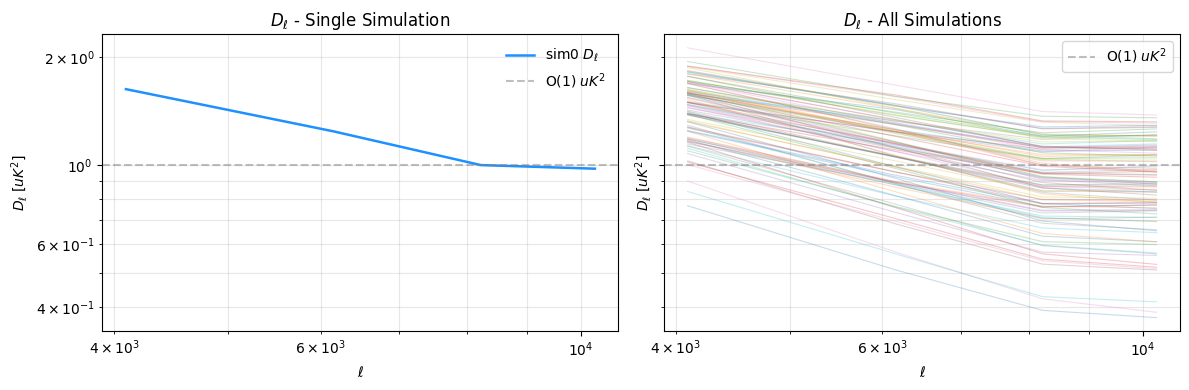

In [37]:
sims_grp = h5f["sims"]
sim_names = sorted(sims_grp.keys(), key=lambda s: (len(s), s))

# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Left Plot: Single Simulation
ax = axes[0]
ax.loglog(ell[1:], Dl[1:], color="dodgerblue", lw=1.8, label="sim0 $D_\\ell$")
ax.axhline(1, ls="--", color="gray", alpha=0.5, label="O(1) $uK^2$")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$D_\ell$ [$uK^2$]")
ax.set_title(r"$D_\ell$ - Single Simulation")
ax.grid(True, which="both", alpha=0.3)
ax.legend(frameon=False)

# Right Plot: All Simulations
ax = axes[1]
for sim in sim_names:
    cl_path = f"sims/{sim}/cl"
    if cl_path not in h5f:
        continue
    ell = h5f[f"{cl_path}/ell"][()]
    Dl  = h5f[f"{cl_path}/dl_ksz"][()]
    ax.loglog(ell[1:], Dl[1:], lw=0.8, alpha=0.25)
ax.axhline(1, ls="--", color="gray", alpha=0.5, label="O(1) $uK^2$")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$D_\ell$ [$uK^2$]")
ax.set_title(r"$D_\ell$ - All Simulations")
ax.grid(True, which="both", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

### Inspect Lengths of ell and dl

In [38]:
ell_lengths = set()
dl_lengths  = set()

for i in h5f["sims"]:
    ell = h5f["sims"][i]["cl"]["ell"][()]
    dl  = h5f["sims"][i]["cl"]["dl_ksz"][()]

    ell_lengths.add(len(ell))
    dl_lengths.add(len(dl))

print("Unique ell lengths:", ell_lengths)
print("Unique dl lengths:", dl_lengths)

Unique ell lengths: {5}
Unique dl lengths: {5}


### Inspect All ell Array Values

In [39]:
sims = list(h5f["sims"].keys())
ell_ref = h5f["sims"][sims[0]]["cl"]["ell"][()]

identical = True
for i in sims[1:]:
    ell = h5f["sims"][i]["cl"]["ell"][()]
    if not np.array_equal(ell, ell_ref):
        identical = False
        print(f"Different ell in {i}")
        break

print("All ell arrays identical?", identical)

All ell arrays identical? True


## Close Files

In [40]:
h5f.close()